Author: Abdulrahman Altahhan, 2024.

The notebook uses a library of functionality in RL that aims for simplicity and general insight into how algorithms work, these libraries are written from scratch using standard Python libraries (numpy, matplotlib etc.).
Please note that you will need permission from the author to use the code for research, commercially or otherwise.

# Lesson 15: Non-linear Action-Value Approximation and Policy Gradient Methods for Control 

**Learning outcomes**
1. build on previous concepts to come up with suitable and sometimes novel algorithms to solve a problem at hand
1. understand how to combine reinforcement learning with non-linear function approximators such as a neurla network to create a powerful framework that allows automatic agent learning by observation or self-play.
1. understand how a replay buffer helps us to come closer to supervised learning and appreciate the important role it plays in reaching convergence for difficult problems that involve image processing and reinforcement learning


**Reading**:
The accompanying reading of this lesson is **chapter 16** of our text book available online [here](http://incompleteideas.net/book/RLbook2020.pdf). Please note that we explain the ideas of this topic from a practical perspective and not from a theoretical perspective which is already covered in the textbook.

This lesson deals with non-linear function approximation and RL, particularly with neural networks combined with RL. We have seen earlier how to deal with linear function approximations and the benefits that they bring in terms of a richer state representation. Now we move to an even richer but integrated and automatic feature extraction via a neural network. We can of course do feature extraction separate from training an RL, but integrating these two stages brings the benefit of extracting features that are particularly useful for the RL algorithm. One of the earliest examples of successfully using a neural network is Tesauro Backgammon [TDGammon](https://en.wikipedia.org/wiki/TD-Gammon). Although the theoretical convergence guarantees do not extend from linear network cases to the non-linear function approximation, however, that did stop researchers from integrating both albeit in a few examples prior to the deep learning era, after which a vast number of models that uses both deep learning and reinforcement learning emerges with impressive results.

We will utilise the idea of an experience replay buffer. We have already seen how to benefit from past experience on a large scale in the planning lesson, where we build a model of the environment. Here, we will not build a model, so we are still in the vicinity of model-free RL, but we will see how to execute a batch of updates instead of one update at a time. Training a neural network is an important addition to our arsenal of techniques because it brings RL closer to how we train supervised learning models, which is useful in two folds. The first is to train based on a mix of old and new experiences is useful for incorporating new experiences without forgetting old experiences. The second is to benefit from the built-in parallelisation of neural network training, which is greatly useful for more complex domains such as games and robotics. 

Note that the replay buffer dictates the choice of an off-policy algorithm, i.e. Q-learning, since the replayed experience is old and the agent will be learning from a policy different to the one it pursues.


### Dependencies

Please refer to libraries installation in the Introduction to find a list of libraries that you will need to install. If you are using the Azure VM then these packages will be already there, so you can get started and jum to the next section. If you cannot find a **list** of pip3 install in the IntroductionTOC notebook then re-download the notebook from minerva.

Let us test if it is working

In [1]:
# !conda list -f tensorflow
# print('-------------check that the two commands give you the same version--------------------')
# print('-------------otherwise it means you are using a kernel without a GPU------------------')
# !pip3 show tensorflow 

We can also check if our GPU is in use as follows.

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
# or
# !python3 -c "import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))"

2025-02-23 16:56:04.777721: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12904346926301707512
xla_global_id: -1
]


In [3]:
from tensorflow.python.platform import build_info as tf_build_info
# print("cudnn_version",tf_build_info.build_info['cudnn_version'])
# print("cuda_version",tf_build_info.build_info['cuda_version'])

Ok, we are ready, let us get started...!

To run this notebook on a remote Azure lab server **without** using remote desktop check this [link](https://docs.microsoft.com/en-us/azure/lab-services/class-type-jupyter-notebook#template-virtual-machine)

## Non-linear Funciton Approximation Reinforcement Learning
First let us import the necessary libraries

In [65]:
%matplotlib inline

In [5]:
from rl.rl import *

In [6]:
import time
import os
import cv2
import numpy as np

import matplotlib.pyplot as plt
from numpy.random import rand
from collections import deque
from itertools import islice
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation

In [7]:
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
# from tensorflow.keras.callbacks import ProgbarLogger

from IPython.display import clear_output

from tensorflow.keras.layers import Conv2D, Dense, Flatten, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


Note that we are importing the basic MRP and MDP classes because this is suitable to create a non-linear MRP and MDP as we do not want to mix up non-linear solutions with linear solutions produced in previous lesson.

# RL with Neural Networks 
It is time to extend our basic MRP class to handle function approximation using neural networks.
Note that in their paper DeepMinds trained for 200M frames, we set the max_t_exp (used in stop_exp() function) to 2M due to hardware limitation. We can also make the stop_exp() tied to R-star that is specific to the application under consideration.

## Buffer Implementation

**If you are familiar with the concepts of deque then please skip to the next [section](#Neural-Network-Based-MRP).** 

It is better to implement the buffer as queue because it guarantees an O(1) complexity for append() and pop() and it is preferred over the list which gives us a O(n) for adding and retrieving an item. In Python we can utilise the double queue structure which gives us the flexibility to add and retrieve from both ends of the queue. Below, we show a quick example. Note that the buffer will be overwritten when. the number of items exceeds its length. This is useful for us because we just want the buffer to overwritten with new experience after it s full and to be kept updated accordingly.

In [8]:
from collections import deque
buffer = deque(maxlen=5)
buffer.append(1)
buffer.append(2)
buffer.append(3)
buffer.append(4)
print(buffer)

deque([1, 2, 3, 4], maxlen=5)


In [9]:
buffer.append(5)
buffer.append(6)
buffer.append(7)
print(buffer)

deque([3, 4, 5, 6, 7], maxlen=5)


To access the last item we use the usual indexing.

In [10]:
print(buffer[-1])
buffer.append(8)
print(buffer[-1])

7
8


### Random Sampling form the Buffer
Let us now take few random samples of size 2 from the buffer.

In [11]:
from random import sample
for i in range(3):
    print(sample(buffer,2))

[4, 8]
[7, 8]
[4, 6]


### Buffer with Complex Element (Tuples)
Let us assume that we have a set of tuples each consists of (s,a,sn). In this case we can add these tuples as is. Below we show an example, we have represented actions as integers but states/observations as string to help identifying them visually, but bear in mind that they are going to be a more complex entities such as images.

In [12]:
buffer = deque(maxlen=4)
buffer.append(('2',1,'3'))
buffer.append(('3',2,'4'))
buffer.append(('4',2,'5'))
buffer.append(('5',1,'4'))

print(buffer)

deque([('2', 1, '3'), ('3', 2, '4'), ('4', 2, '5'), ('5', 1, '4')], maxlen=4)


Now in order to sample we can directly sample from the buffer 

In [13]:
batch = sample(buffer,3)
print(batch)

[('2', 1, '3'), ('5', 1, '4'), ('3', 2, '4')]


However, the above is not useful, usually we want to place all the actions and states and next states in their own list to feed them as a batch into a neural network. To put all states and actions together each in its own list we can use zip

In [14]:
for i in zip(*batch): print(i)

('2', '5', '3')
(1, 1, 2)
('3', '4', '4')


We can also convert them into a numpy array directly.

In [15]:
[np.array(i) for i in zip(*batch)]

[array(['2', '5', '3'], dtype='<U1'),
 array([1, 1, 2]),
 array(['3', '4', '4'], dtype='<U1')]

In [16]:
buffer = deque(maxlen=4)
buffer.append(('2',1,'3'))
buffer.append(('3',2,'4'))
buffer.append(('4',2,'5'))
buffer.append(('5',1,'4'))
buffer.append(('7',8,'6'))

print(buffer)
samples = [np.array(item) for item in zip(*sample(buffer,3))]
print(samples)

deque([('3', 2, '4'), ('4', 2, '5'), ('5', 1, '4'), ('7', 8, '6')], maxlen=4)
[array(['5', '7', '4'], dtype='<U1'), array([1, 8, 2]), array(['4', '6', '5'], dtype='<U1')]


sampling an empty batch

In [17]:
nbatch = 1
sample(buffer, nbatch-1)

[]

sampling last nbatch elements from the buffer

In [18]:
nbatch = 3
def slice_(buffer):
    return list(islice(buffer,len(buffer)-nbatch,len(buffer)))

In [19]:
slice_(buffer)

[('4', 2, '5'), ('5', 1, '4'), ('7', 8, '6')]


## Neural Network Based MRP
In this class we implement the basic functionality for dealing with creating, saving and loading deep learning models. In addition, we make these models the default functions used to obtain the value function via self.V_.
We also adjust the stope_exp criterion so that the algorithm stops when a specific averaged reward is achieved or when a specific *total* number of steps (self.t_ not self.t) have been elapsed. This means also that we free ourselves from the notion of an episode, so our model can run as many episodes as it takes to achieve this total number of steps. We still can assign episodes=x to store metrics for last y episodes where y<x.
Note that nF is usually used in the Env(ironment) class but feature extraction is embedded the model itself in deep learning model so it is defined in the Deep_MRP class.

In [20]:
class nnMRP(MRP):
    def __init__(self, γ=0.99, nF=512, nbuffer=10000, nbatch=32, rndbatch=True,
                 save_weights=1000,     # save weights every now and then
                 load_weights=False,
                 print_=True,
                 **kw):
        
        super().__init__(γ=γ, **kw)
        self.nF = nF   # feature extraction is integrated within the neural network model not the env
        
        self.nbuffer  = nbuffer
        self.nbatch   = nbatch
        self.rndbatch = rndbatch
        
        self.load_weights_= load_weights
        self.save_weights_= save_weights # used to save the target net every now and then
        
        self.update_msg = 'update %s network weights...........! %d'
        self.saving_msg = 'saving %s network weights to disk...! %d'
        self.loading_msg = 'loading %s network weights from disk...!'
        
    def init(self):
        self.vN = self.create_model('V')                      # create V deep network
        if self.load_weights_: self.load_weights(self.vN,'V.weights.h5') # from earlier training proces   
        self.V = self.V_

    #-------------------------------------------Deep model related---------------------------
    def create_model(self, net_str):
        x0 = Input(self.env.reset().shape)#(84,84,1))#self.env.frame_size_)
        x = Conv2D(32, 8, 4, activation='relu')(x0)
        x = Conv2D(64, 4, 2, activation='relu')(x)
        x = Conv2D(64, 3, 1, activation='relu')(x)
        x = Flatten()(x)
        x = Dense(self.nF, 'relu')(x)
        x = Dense(1 if net_str=='V' else self.env.nA)(x) 
        model = Model(x0, x)
        model.compile(Adam(self.α), loss='mse')
        model.summary() if net_str != 'Qn' else None
        model.net_str = net_str
        return model

    def load_weights(self, net, net_str ):
        print(self.loading_msg%net_str)
        loaded_weights = net.load_weights(net_str)
        loaded_weights.assert_consumed()

    def save_weights(self):
        print(self.saving_msg%('V ',self.t_))
        self.vN.save_weights('V.weights.h5')

    #------------------------------------- value related 🧠-----------------------------------
    def V_(self, s, Vs=None):
        
        # update the V network if Vs is passed
        if Vs is not None: self.vN.fit(s, Vs, verbose=False); return None
        
        # predict for one state for εgreedy, or predict for a batch of states, copy to avoid auto-grad issues
        return self.vN.predict(np.expand_dims(s, 0), verbose=0)[0] if len(s.shape)!=4 else np.copy(self.vN.predict(s, verbose=0)) 
    
    #-------------------------------------------buffer related----------------------------------
    def allocate(self):
        self.buffer = deque(maxlen=self.nbuffer)

    def store_(self, s=None,a=None,rn=None,sn=None,an=None, done=None, t=0):
        self.save_weights() if self.save_weights_ and self.t_%self.save_weights_==0 else None
        self.buffer.append((s, a, rn, sn, done))
    
    # deque slicing, cannot use buffer[-nbatch:]
    def slice_(self, buffer, nbatch):
        return list(islice(buffer, len(buffer)-nbatch, len(buffer)))
    
    def batch(self):
        # if nbatch==nbuffer==1 then (this should give the usual qlearning without replay buffer)
        # sample nbatch tuples (each tuple has 5 items) without replacement or obtain latest nbatch from the buffer
        # zip the tuples into one tuple of 5 items and convert each item into a np array of size nbatch 
        
        samples = sample(self.buffer, self.nbatch) if self.rndbatch else self.slice_(self.buffer, self.nbatch)
        samples = [np.array(experience) for experience in zip(*samples)]
        
        # generate a set of indices handy for filtering, to be used in online()
        inds = np.arange(self.nbatch)
        
        return samples, inds


## Neural Network Based MDP
Now we create the MDP class which implements policy related functionality

In [21]:
class nnMDP(MDP(nnMRP)):

    # update the target network every t_qNn steps
    def __init__(self, create_vN=False, **kw):
        super().__init__(**kw)
        self.create_vN = create_vN

    def init(self):
        super().init() if self.create_vN else None                     # to create also vN, suitable for actor-critic
        self.qN  = self.create_model('Q')                              # create main policy network
        self.qNn = self.create_model('Qn')                             # create target network to estimate Q(sn)

        self.load_weights(self.qN,'Q.weights.h5') if self.load_weights_ else None # from earlier training proces
        self.load_weights(self.qNn,'Q.weights.h5') if self.load_weights_ else None # from earlier training proces

        self.Q = self.Q_

    def save_weights(self):
        super().save_weights() if self.create_vN else None             # save vN weights, for actor-critic
        print(self.saving_msg%('Q', self.t_))
        self.qN.save_weights('Q.weights.h5')
    
    def set_weights(self, net):
        print(self.update_msg%(net.net_str, self.t_))
        net.set_weights(self.qN.get_weights())
        
    #------------------------------------- policies related 🧠-----------------------------------
    def Q_(self, s, Qs=None):
        # update the Q networks if Qs is passed
        if Qs is not None: self.qN.fit(s, Qs, verbose=0); return None

        # predict for one state for εgreedy, or predict for a batch of states, 
        # copy to avoid auto-grad issues
        return self.qN.predict(np.expand_dims(s, 0), verbose=0)[0] if len(s.shape)!=4 \
    else np.copy(self.qN.predict(s, verbose=0))

    def Qn(self, sn, update=False):
        # update the Qn networks if Qn is passed
        if update: self.set_weights(self.qNn); return None
        return self.qNn.predict(sn, verbose=0)

Bellow we double-check that the policies assigned via class inheritance is suitable. MRP should have a stationary policy while MDP has an εgreedy policy.

In [22]:
print(nnMRP().policy)
print(nnMDP().policy)

<bound method MRP.stationary of <__main__.nnMRP object at 0x14c455b80>>
<bound method MDP.<locals>.MDP.εgreedy of <__main__.nnMDP object at 0x14c455b50>>


## Deep Q-Learning Architecture


Note that we need to set ε here otherwise it will be set by default to .1 in the parent class.

In [23]:
class DQN(nnMDP):
    def __init__(self, α=1e-4, t_Qn=1000, **kw): 
        print('--------------------- 🧠  DQN is being set up 🧠 -----------------------')
        super().__init__(**kw)
        self.α = α
        self.store = True
        self.t_Qn = t_Qn
        
    #------------------------------- 🌖 online learning ---------------------------------
    # update the online network in every step using a batch
    def online(self, *args):
        # no updates unless the buffer has enough samples
        if len(self.buffer) < self.nbuffer: return
        
        # sample a tuple batch: each component is a batch of items 
        # (s and a are sets of states and actions)
        (s, a, rn, sn, dones), inds = self.batch() 

        # obtain the action-values estimation from the two networks and 
        # ensure target is 0 for terminal states
        Qs = self.Q(s)
        Qn = self.Qn(sn); Qn[dones] = 0

        # now dictate what the target should have been as per the Q-learning update rule
        Qs[inds, a] = self.γ*Qn.max(1) + rn
        
        # then update both
        self.Q(s, Qs)
        self.Qn(sn, self.t_%self.t_Qn==0)


Let us now deal with Grid as a game and state as images. We will try first just to run as usual without sampling but with randomisation form the buffer. To do so, we simply assign the same number for the nbuffer and nbatch which will force the algorithm to pass all of what it has in the buffer albeit randomised in terms of order.

To properly force the algorithm not to randomise the samples, we can pass this flag explicitly.

CPU times: user 3h 32min 14s, sys: 44min 36s, total: 4h 16min 50s
Wall time: 3h 11min 34s


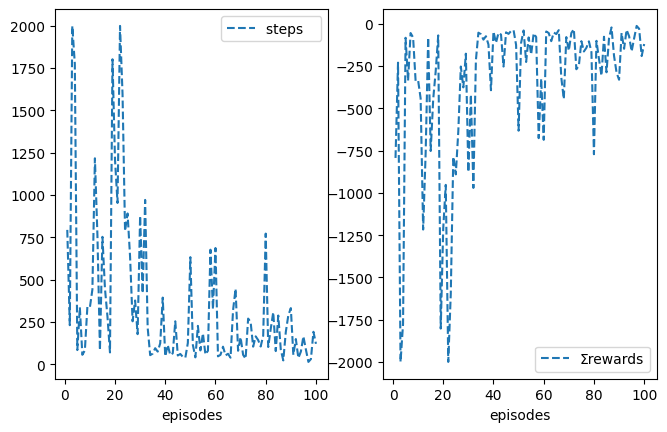

In [24]:
# deal with the Grid states as images and learn from them to navigate it
# please be patient as it takes much longer to learn from pixles


%time nqlearn = DQN(env=iGrid(style='maze', reward='reward_1'), seed=10, episodes=100, \
                    rndbatch=False, t_Qn=500, nbuffer=32, nbatch=32, **demoGame()).interact() 

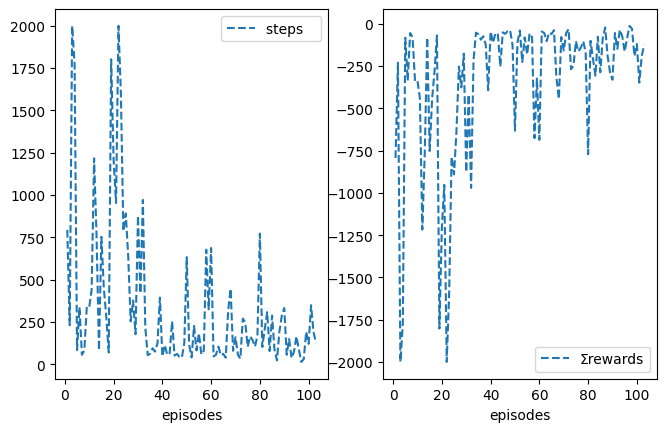

In [25]:
nqlearn.interact(resume=True, episodes=103, **demoGame())

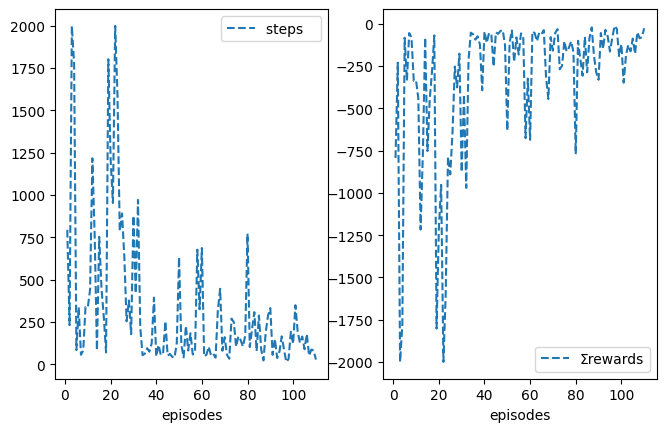

In [26]:
nqlearn.interact(resume=True, episodes=110, view=10, **demoGame())

CPU times: user 6h 47min 50s, sys: 58min 54s, total: 7h 46min 45s
Wall time: 6h 44min 8s


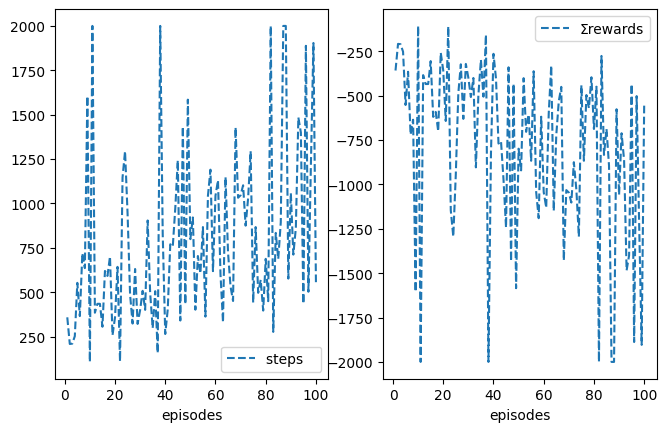

In [27]:
# deal with the Grid states as images and learn from them to navigate it
%time nqlearn = DQN(env=iGrid(style='maze', reward='reward_1'), seed=10, \
                    episodes=100, nbuffer=1, nbatch=1, **demoGame()).interact() 

CPU times: user 4h 57min 59s, sys: 49min 30s, total: 5h 47min 30s
Wall time: 4h 39min 39s


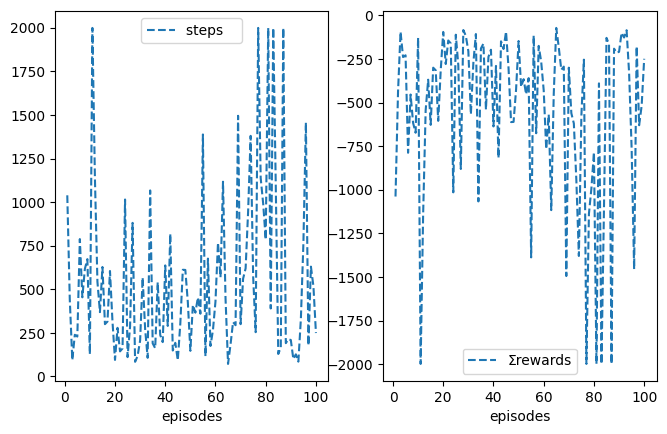

In [28]:
# deal with the Grid states as images and learn from them to navigate it
%time nqlearn = DQN(env=iGrid(style='maze', reward='reward_1'), seed=10, \
                    episodes=100, nbuffer=8, nbatch=8, **demoGame()).interact()

CPU times: user 1h 49min 58s, sys: 15min 27s, total: 2h 5min 26s
Wall time: 1h 33min 50s


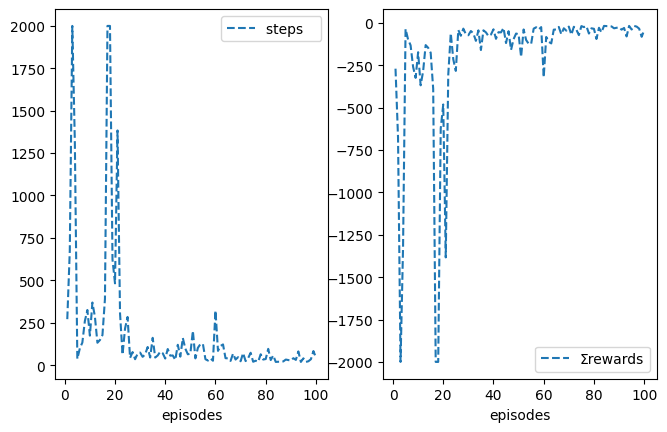

In [30]:
# deal with the Grid states as images and learn from them to navigate it
%time nqlearn = DQN(env=iGrid(style='maze', reward='reward_1'), \
                    seed=10, episodes=100, nbuffer=1000, nbatch=32, **demoGame()).interact() 

In [31]:
nqlearn.policy

<bound method MDP.<locals>.MDP.εgreedy of <__main__.DQN object at 0x19819fc20>>

In [32]:
print(nqlearn.env.img.shape)

(50, 84, 1)


CPU times: user 23min 48s, sys: 3min 35s, total: 27min 24s
Wall time: 19min 47s


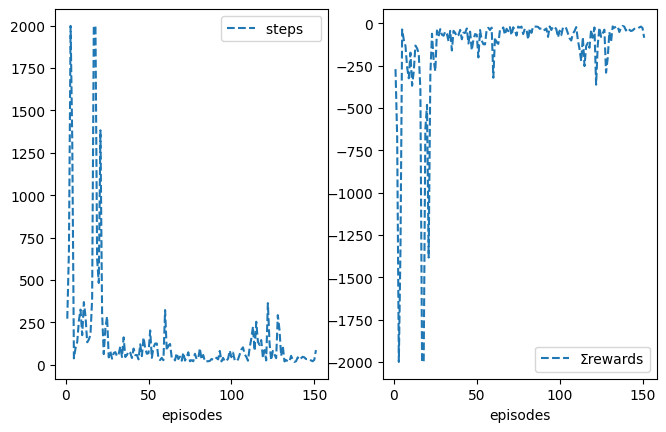

In [33]:
%time nqlearn.interact(resume=True, episodes=151, **demoGame())

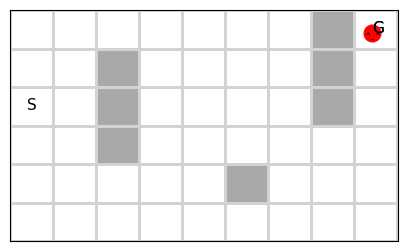

In [68]:
nqlearn.env.render__()

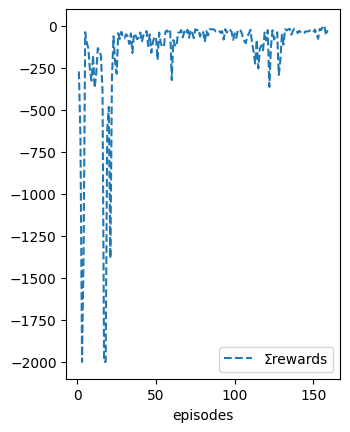

In [62]:
# nqlearn.ep -=1
# nqlearn.plotT = False
# nqlearn.visual = True
# nqlearn.underhood='maxQ' # uncomment to see also the policy
nqlearn.interact(resume=True, episodes=159, plotT=True)

In [36]:
plt.imread('img/img0.png').shape

(231, 387, 4)

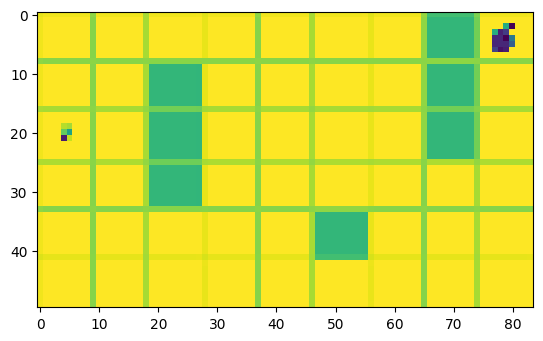

In [37]:
plt.imshow(nqlearn.env.img)

In [38]:
163*278*4

181256

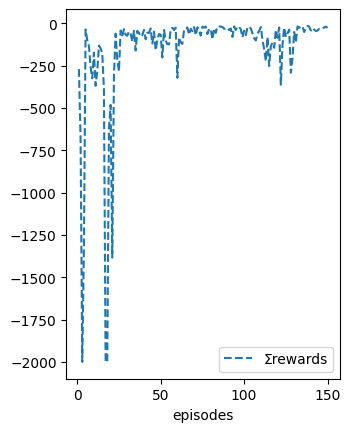

In [39]:
nqlearn.env.img=None
nqlearn.env.i=0
nqlearn.ep -=1
nqlearn.plotT = False
nqlearn.visual = True
# nqlearn.underhood='maxQ' # uncomment to see also the policy
nqlearn.interact(train=False, **demoGame())

## Double DQN Learning

In [40]:
class DDQN(DQN):
    def __init__(self, α=1e-4, **kw):
        print('----------- 🧠 Double DQN is being set up 🧠 ---------------------')
        super().__init__(**kw)
        self.α = α
        self.store = True
    #--------------------------- 🌖 online learning -----------------------------
    def online(self, *args):
        # sample a tuple batch: each component is a batch of items 
        #(ex. s is a set of states, a is a set of actions) 
        (s, a, rn, sn, dones), inds = self.batch()
        
        # obtain the action-values estimation from the two networks 
        # and make sure the target is 0 for terminal states
        Qs = self.Q(s)
        Qn = self.Qn(sn); Qn[dones] = 0

        # now dictate what the target should have been as per the *Double* Q-learning 
        # update rule, this is where the max estimations are decoupled from the max 
        # action selections
        an_max = self.Q(sn).argmax(1)
        Qs[inds, a] = self.γ*Qn[inds, an_max] + rn

        # update
        self.Q(s, Qs) 
        self.Qn(sn, self.t_%self.t_Qn==0)


In [70]:
# %time ddqlearn = DDQN(env=Gridi(style='maze'), seed=10, episodes=2, max_t=200, \
#                       max_t_exp=2000, nbuffer=100, nbatch=32, **demoGame()).interact() 


## Conclusion
In this lesson you saw how to deal with a continuous state space using function approximation and how to apply previous concepts on a more difficult control problems. We have built a wrapper class that allowed us to take advantage of the environments provided by OpenAI Gym library. We have duplicated what we have done in the previous lesson in order to 1. examine that our previous environment worked well, 2. see an example of how to deal with OpenAI Gym environment. 

You have also seen how to combine deep learning with reinforcement learning to create a powerful model that is capable of learning from watching a game. This is really interesting since it opens up the possibility for enormous applications where an agent can watch and learn to arrive to a complex behaviour that allows it to accomplish a task or win a competition. 


## Discussion and Activity
Read the following classic Nips [paper](https://deepmind.com/research/publications/2019/playing-atari-deep-reinforcement-learning) and Nature [paper](https://storage.googleapis.com/deepmind-media/DQN/DQNNaturePaper.pdf) and discuss it in the discussion forum.

## Your turn

1. try to apply the same concept on other simple environments provided by Gym such as the acrobot.

2. apply DQN on another Atari game such as SpaceInvaders or Breakout and report the score that you got in the discussion forum.

## Challenge++
1. check the implementation of the deep network in the [tutorial](https://keras.io/examples/rl/actor_critic_cartpole/) and try to integrate it into the provided infrastructure.

[Back to TOC](IntroductionTOC.ipynb)